<a href="https://colab.research.google.com/github/PaulinaPacyna/SNARS/blob/master/SNARS12_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import ast
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib import pylab
from collections import Counter
import networkx as nx
import itertools
from sklearn.cluster import k_means
from scipy.sparse.linalg import eigs
from scipy import sparse

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
users = pd.read_csv("drive/MyDrive/trolls/users.csv")
tweets = pd.read_csv("drive/MyDrive/trolls/tweets.csv")

In [4]:
tweets.head()

,user_id,user_key,created_at,created_str,retweet_count,retweeted,favorite_count,text,tweet_id,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id
0,2.532612e+09,kathiemrr,1.488207e+12,2017-02-27 14:54:00,NaN,NaN,NaN,#ThingsDoneByMistake kissing auntie in the lips,8.362279e+17,NaN,"[""ThingsDoneByMistake""]",[],POSTED,[],NaN,NaN
1,2.531160e+09,traceyhappymom,1.471273e+12,2016-08-15 14:50:20,NaN,NaN,NaN,RT @mc_derpin: #TheOlderWeGet the more pessimi...,7.651989e+17,NaN,"[""TheOlderWeGet""]",[],POSTED,[],NaN,NaN
2,NaN,evewebster373,1.435701e+12,2015-06-30 21:56:09,NaN,NaN,NaN,RT @dmataconis: Ready To Feel Like A Failure? ...,6.160023e+17,NaN,[],[],POSTED,[],NaN,NaN
3,4.840552e+09,blacktolive,1.474013e+12,2016-09-16 08:04:48,18.0,False,17.0,Amen! #blacklivesmatter https://t.co/wGffaOqgzl,7.766933e+17,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","[""Blacklivesmatter""]",[],POSTED,[],NaN,NaN
4,1.694026e+09,jacquelinisbest,1.474228e+12,2016-09-18 19:46:25,0.0,False,0.0,RT @NahBabyNah: Twitchy: Chuck Todd caught out...,7.775946e+17,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","[""WakeUpAmerica""]","[""http://ln.is/twitchy.com/loriz-31/3yafU""]",POSTED,"[""nahbabynah""]",7.775915e+17,NaN


In [5]:
users.head()

,id,location,name,followers_count,statuses_count,time_zone,verified,lang,screen_name,description,created_at,favourites_count,friends_count,listed_count
0,100345056.0,still ⬆️Block⤵️Corner⬇️street,#Ezekiel2517✨...,1053.0,31858.0,NaN,False,en,SCOTTGOHARD,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,Tue Dec 29 23:15:22 +0000 2009,2774.0,1055.0,35.0
1,247165706.0,"Chicago, IL",B E C K S T E R✨,650.0,6742.0,Mountain Time (US & Canada),False,en,Beckster319,Rebecca Lynn Hirschfeld Actress.Model.Writer.A...,Fri Feb 04 06:38:45 +0000 2011,7273.0,896.0,30.0
2,249538861.0,NaN,Chris Osborne,44.0,843.0,NaN,False,en,skatewake1994,NaN,Wed Feb 09 07:38:44 +0000 2011,227.0,154.0,1.0
3,449689677.0,NaN,Рамзан Кадыров,94773.0,10877.0,Moscow,False,ru,KadirovRussia,"Пародийный аккаунт. Озвучиваю то, что политика...",Thu Dec 29 11:31:09 +0000 2011,0.0,7.0,691.0
4,471868887.0,"Санкт-Петербург, Россия",Маргарита Саваж,23305.0,18401.0,Volgograd,False,ru,MargoSavazh,Честь имею. Нагло врать не умею.,Mon Jan 23 10:26:25 +0000 2012,1480.0,8021.0,231.0


In [6]:
tweets.size, users.size

(3255216, 6342)

In [7]:
G = nx.Graph()
for index, row in tweets.iterrows():
    mentioned = ast.literal_eval(row.mentions)
    for i in mentioned:
      G.add_edge(i, row.user_key)
len(G.nodes()), len(G.edges()) 

(14153, 33157)

(array([1.413e+04, 1.700e+01, 4.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.0000e+00, 3.9940e+02, 7.9780e+02, 1.1962e+03, 1.5946e+03,
        1.9930e+03, 2.3914e+03, 2.7898e+03, 3.1882e+03, 3.5866e+03,
        3.9850e+03]),
 <a list of 10 Patch objects>)

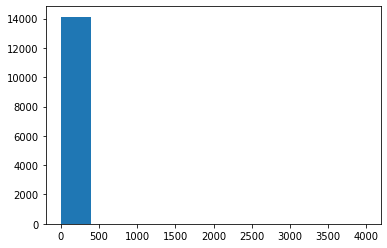

In [26]:
plt.hist(list(dict(G.degree).values()))

In [8]:
N_clusters = 4
def prepare_laplacian(A: np.matrix) -> np.matrix:
    """Given an adjacency matrix, computes the laplacian matrix"""
    return sparse.csr_matrix(A - np.diag(A.sum(axis=0)))
def get_features(L: np.matrix, K: int) -> np.matrix:
    """Given a Laplacian matrix, return the feature vector based on eigenvalues"""
    return eigs(L, k=K, which = 'LR')[1]
def spectral_clustering(G: nx.Graph, K: int):
    """Performs spectral clustering on an adjacency matrix"""
    features = np.real(get_features(prepare_laplacian(nx.to_numpy_matrix(G)), K))
    return k_means(features, K)[1]
labels = spectral_clustering(G, N_clusters)

In [9]:
user_to_cluster_mapping = dict(zip(G.nodes, labels))
tweets['cluster'] = tweets['user_key'].map(user_to_cluster_mapping)
Counter(tweets['cluster']).most_common(5)

[(0.0, 86931), (2.0, 83468), (1.0, 9269), (3.0, 6813), (nan, 1)]

In [10]:
def get_all_hashtags(column: pd.Series) -> list:
   return itertools.chain.from_iterable([ast.literal_eval(u) for u in column.unique()])
for cluster in range(N_clusters):
  col = tweets['hashtags'][tweets['cluster'] == cluster]
  print(Counter(get_all_hashtags(col)).most_common(10))

[('maga', 1049), ('Trump', 768), ('tcot', 561), ('NeverHillary', 453), ('TrumpPence16', 354), ('pjnet', 321), ('TrumpTrain', 295), ('Hillary', 291), ('Trump2016', 273), ('CrookedHillary', 251)]
[('maga', 399), ('Trump', 241), ('NeverHillary', 234), ('TrumpPence16', 148), ('TrumpTrain', 143), ('tcot', 141), ('Trump2016', 129), ('Hillary', 91), ('CrookedHillary', 85), ('HillaryClinton', 77)]
[('Trump', 300), ('maga', 205), ('tcot', 202), ('TrumpForPresident', 168), ('HillaryClinton', 128), ('Clinton', 113), ('NeverHillary', 111), ('Trump2016', 99), ('TrumpPence16', 99), ('pjnet', 89)]
[('maga', 299), ('Trump', 235), ('tcot', 169), ('NeverHillary', 141), ('Hillary', 114), ('LNYHBT', 94), ('TGDN', 92), ('TrumpPence16', 80), ('Obama', 65), ('Trump2016', 53)]


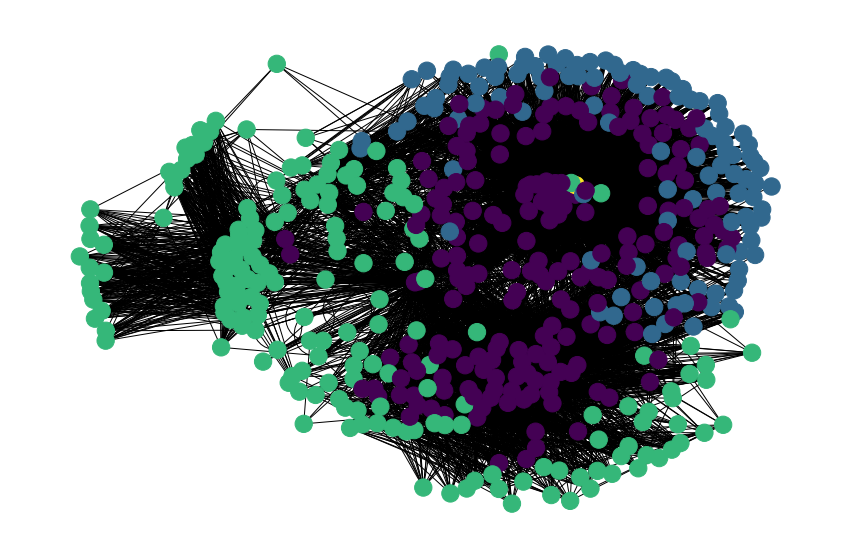

In [25]:
highest_degrees = [k for k, v in sorted(dict(G.degree).items(), key=lambda item: -item[1])][:500]
subgraph = nx.subgraph(G, highest_degrees) 
nx.draw_kamada_kawai(subgraph, node_color=[user_to_cluster_mapping[user] for user in subgraph.nodes()], ax=plt.subplots(figsize=(15,10))[1])